Attempt 2 Using better ICA Gpu Rendered

In [10]:
import mne
import numpy as np
from torcheeg.datasets import SEEDDataset
import os
from collections import defaultdict

# ---------------------------------------------------------------
# Load the SEED Dataset
# ---------------------------------------------------------------
dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=6
)

# ---------------------------------------------------------------
# Directory to Save the Cleaned Data
# ---------------------------------------------------------------
save_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data'
os.makedirs(save_dir, exist_ok=True)

# ---------------------------------------------------------------
# Group Samples by Record ID
# ---------------------------------------------------------------
record_groups = defaultdict(list)

for idx in range(len(dataset)):
    eeg_data, label = dataset[idx]
    record_id = label['_record_id']
    record_groups[record_id].append(eeg_data)

# ---------------------------------------------------------------
# Process Each Unique Record
# ---------------------------------------------------------------
for record_id, eeg_samples in record_groups.items():
    print(f"Processing record {record_id}...")

    # Concatenate all samples within the record along the time axis
    eeg_data = np.hstack(eeg_samples)  # Shape: (channels, combined_time_points)

    # Create MNE info object
    sfreq = 200  # Original sampling frequency (200 Hz)
    ch_names = [f'Ch{i+1}' for i in range(eeg_data.shape[0])]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))

    # Create MNE Raw object
    raw = mne.io.RawArray(eeg_data, info)

    # Assign a standard montage
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.rename_channels({f'Ch{i+1}': montage.ch_names[i] for i in range(len(ch_names))})
    raw.set_montage(montage)

    # -------------------------------------------------------------------------
    # Preprocessing: Bandpass Filter (0.05–47 Hz) and Downsampling
    # -------------------------------------------------------------------------
    print(f"Applying 0.05–47 Hz bandpass filter for record {record_id}...")
    raw.filter(l_freq=0.05, h_freq=47.0, fir_design='firwin')

    # Downsample to 100 Hz to speed up ICA
    print(f"Downsampling to 100 Hz for record {record_id}...")
    raw.resample(sfreq=100)

    # -------------------------------------------------------------------------
    # Apply ICA for Artifact Removal (Infomax)
    # -------------------------------------------------------------------------
    print(f"Applying Infomax ICA for artifact removal on record {record_id}...")

    # Set ICA parameters to use Infomax with a reduced number of components
    ica = mne.preprocessing.ICA(
        n_components=len(ch_names) - 1, # Limit to 30 components for faster processing
        method='infomax',      # Use Infomax algorithm as specified in the paper
        max_iter=200,          # Default max_iter
        random_state=42
    )

    # Fit ICA to the data
    ica.fit(raw, picks='all')

    # -------------------------------------------------------------------------
    # Automatically Detect and Limit Exclusions to 2 Worst Components
    # -------------------------------------------------------------------------
    # Define virtual EOG channels (frontal electrodes)
    eog_virtual_channels = ['Fp1', 'Fp2']

    try:
        # Detect EOG artifacts using virtual EOG channels
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=eog_virtual_channels)
        print(f"EOG components identified: {eog_indices}")
    except RuntimeError:
        print("No suitable EOG channels found. Skipping EOG artifact detection.")
        eog_indices, eog_scores = [], []

    # Detect muscle artifacts
    muscle_indices, muscle_scores = ica.find_bads_muscle(raw)
    print(f"Muscle artifact components identified: {muscle_indices}")

    # Combine indices and scores
    # Combine indices and scores
    # Combine indices and scores
    all_indices = eog_indices + muscle_indices
    all_scores = eog_scores + muscle_scores

    # Ensure all scores are scalar values by taking the maximum absolute value if they are arrays
    all_scores = [np.max(np.abs(score)) if isinstance(score, (np.ndarray, list)) else abs(score) for score in all_scores]

    # Limit to the 2 worst components (highest scores)
    if len(all_indices) > 2:
        worst_indices = [idx for _, idx in sorted(zip(all_scores, all_indices), key=lambda x: x[0], reverse=True)[:2]]
    else:
        worst_indices = all_indices

    # Set components to exclude
    ica.exclude = worst_indices
    print(f"Excluded components for record {record_id}: {ica.exclude}")



    # Apply ICA to remove the selected components
    ica.apply(raw)

    # -------------------------------------------------------------------------
    # Save the Cleaned Data
    # -------------------------------------------------------------------------
    save_path = os.path.join(save_dir, f'cleaned_{record_id}.fif')
    raw.save(save_path, overwrite=True)
    print(f"Processed and saved record {record_id} to {save_path}")

print("All records have been processed and saved successfully.")


[2024-12-09 17:47:23] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Processing record _record_0...
Applying 0.05–47 Hz bandpass filter for record _record_0...
Downsampling to 100 Hz for record _record_0...
Applying Infomax ICA for artifact removal on record _record_0...
EOG components identified: [2, 23]
Muscle artifact components identified: [5, 7, 10, 17, 22, 24, 26, 29, 30, 35, 36, 37, 38, 42, 44, 46, 47, 48, 51, 53, 56, 58]
Excluded components for record _record_0: [2, 23]
Processed and saved record _record_0 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_0.fif
Processing record _record_1...
Applying 0.05–47 Hz bandpass filter for record _record_1...
Downsampling to 100 Hz for record _record_1...
Applying Infomax ICA for artifact removal on record _record_1...
EOG components identified: [4]
Muscle artifact components identified: [2, 3, 4, 6, 18, 21, 22, 23, 28, 31, 35, 37, 40, 41, 42, 43, 44, 48, 49, 54, 55, 57, 58, 59, 60]
Excluded components for record _record_1: [4, 2]
Processed and saved record _record_1 

In [5]:
import mne
import numpy as np
from torcheeg.datasets import SEEDDataset
import os

# ---------------------------------------------------------------
# Load the SEED Dataset
# ---------------------------------------------------------------
dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=6
)

# Load a single sample to test
eeg_data, label = dataset[0]

# Create MNE info object
sfreq = 200  # Sampling frequency (200 Hz)
ch_names = [f'Ch{i+1}' for i in range(eeg_data.shape[0])]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))

# Create MNE Raw object
raw = mne.io.RawArray(eeg_data, info)

# Assign a standard montage
montage = mne.channels.make_standard_montage('standard_1005')
raw.rename_channels({f'Ch{i+1}': montage.ch_names[i] for i in range(len(ch_names))})
raw.set_montage(montage)

# Apply bandpass filtering (0.05–47 Hz)
raw.filter(l_freq=0.05, h_freq=47.0, fir_design='firwin')

# Create ICA object with fewer components and fit on a small subset of data
ica = mne.preprocessing.ICA(
    n_components=20,       # Use fewer components to speed up the process
    method='infomax',
    max_iter=100,          # Reduce iterations for quicker fitting
    random_state=42
)

# Fit ICA on the available duration of data
raw_subset = raw.copy().crop(tmin=0, tmax=raw.times[-1])
ica.fit(raw_subset, picks='all')

# Check virtual EOG channels
eog_virtual_channels = ['Fp1', 'Fp2']  # Adjust based on your montage

try:
    # Attempt to find EOG artifacts
    eog_indices, eog_scores = ica.find_bads_eog(raw_subset, ch_name=eog_virtual_channels)
    print(f"EOG components identified: {eog_indices}")
except RuntimeError as e:
    print(f"Error: {e}")


[2024-12-09 17:02:39] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


EOG components identified: [0]


In [9]:
# Mock scores for quick testing
eog_scores = [np.array([0.8]), np.array([-0.5])]
muscle_scores = [np.array([0.3]), np.array([0.7]), np.array([-0.9])]

# Combine indices and scores for testing
eog_indices = [2, 23]
muscle_indices = [5, 7, 10]

all_indices = eog_indices + muscle_indices
all_scores = eog_scores + muscle_scores

# Ensure all scores are scalar values
all_scores = [np.max(np.abs(score)) if isinstance(score, (np.ndarray, list)) else abs(score) for score in all_scores]

# Print the processed scores
print(f"Processed all_scores: {all_scores}")

# Limit to the 2 worst components
if len(all_indices) > 2:
    worst_indices = [idx for _, idx in sorted(zip(all_scores, all_indices), key=lambda x: x[0], reverse=True)[:2]]
else:
    worst_indices = all_indices

print(f"Worst components to exclude: {worst_indices}")


Processed all_scores: [0.8, 0.5, 0.3, 0.7, 0.9]
Worst components to exclude: [10, 2]


Denoising and Bandpass 4-47

In [1]:
import mne
import numpy as np
import os

# ---------------------------------------------------------------
# Directories for Cleaned and Denoised Data
# ---------------------------------------------------------------
cleaned_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data'
denoised_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data'
os.makedirs(denoised_dir, exist_ok=True)

# ---------------------------------------------------------------
# Function for Automatic Denoising
# ---------------------------------------------------------------
def denoise_eeg(raw, threshold=3, noisy_channel_ratio=0.3, spike_threshold=100):
    # Get data and channel names
    data = raw.get_data()
    ch_names = raw.info['ch_names']
    
    # Identify noisy channels
    noisy_channels = []
    for i in range(data.shape[0]):
        median_abs = np.median(np.abs(data[i]))
        outliers = np.abs(data[i]) > (threshold * median_abs)
        if np.sum(outliers) / data.shape[1] > noisy_channel_ratio:
            noisy_channels.append(ch_names[i])
    
    print(f"Noisy channels identified: {noisy_channels}")

    # Interpolate noisy channels
    if noisy_channels:
        raw.info['bads'] = noisy_channels
        raw.interpolate_bads(reset_bads=True, mode='nearest')

    # Fix remaining spikes
    for i in range(data.shape[0]):
        diffs = np.abs(np.diff(data[i]))
        spike_indices = np.where(diffs > spike_threshold)[0]
        for idx in spike_indices:
            data[i, idx + 1] = data[i, idx]

    # Update raw object with cleaned data
    raw._data = data
    return raw

# ---------------------------------------------------------------
# Process Each Cleaned File
# ---------------------------------------------------------------
for filename in os.listdir(cleaned_dir):
    if filename.endswith('.fif'):
        record_id = filename.split('.')[0]
        cleaned_path = os.path.join(cleaned_dir, filename)
        
        print(f"Processing file {filename}...")

        # Load the cleaned data
        raw = mne.io.read_raw_fif(cleaned_path, preload=True)

        # -------------------------------------------------------------------------
        # Automatic Denoising
        # -------------------------------------------------------------------------
        print(f"Performing automatic denoising for {record_id}...")
        raw = denoise_eeg(raw)

        # -------------------------------------------------------------------------
        # Bandpass Filter (4–47 Hz)
        # -------------------------------------------------------------------------
        print(f"Applying 4–47 Hz bandpass filter for {record_id}...")
        raw.filter(l_freq=4.0, h_freq=47.0, fir_design='firwin')

        # -------------------------------------------------------------------------
        # Re-reference to Common Average
        # -------------------------------------------------------------------------
        print(f"Re-referencing to common average for {record_id}...")
        raw.set_eeg_reference('average', projection=False)

        # -------------------------------------------------------------------------
        # Save the Denoised Data
        # -------------------------------------------------------------------------
        save_path = os.path.join(denoised_dir, f'denoised_{record_id}.fif')
        raw.save(save_path, overwrite=True)
        print(f"Processed and saved {record_id} to {save_path}")

print("All cleaned records have been denoised and saved successfully.")


Processing file cleaned__record_0.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_0.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_0...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_0...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_0...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_0.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_0.fif
[done]
Processed and saved cleaned__record_0 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_0.fif
Processing file cleaned__record_1.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_1.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Performing automatic denoising for cleaned__record_1...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_1...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Re-referencing to common average for cleaned__record_1...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_1.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_1.fif
[done]
Processed and saved cleaned__record_1 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_1.fif
Processing file cleaned__record_10.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_10.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Performing automatic denoising for cleaned__record_10...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_10...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_10...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_10.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_10.fif
[done]
Processed and saved cleaned__record_10 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_10.fif
Processing file cleaned__record_11.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_11.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Performing automatic denoising for cleaned__record_11...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_11...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_11...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_11.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_11.fif
[done]
Processed and saved cleaned__record_11 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_11.fif
Processing file cleaned__record_12.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_12.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_12...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_12...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_12...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_12.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_12.fif
[done]
Processed and saved cleaned__record_12 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_12.fif
Processing file cleaned__record_13.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_13.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_13...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_13...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_13...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_13.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_13.fif
[done]
Processed and saved cleaned__record_13 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_13.fif
Processing file cleaned__record_14.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_14.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_14...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_14...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_14...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_14.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_14.fif
[done]
Processed and saved cleaned__record_14 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_14.fif
Processing file cleaned__record_15.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_15.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_15...
Noisy channels identified: ['F7', 'FT7']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.1 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 2 sensors
Applying 4–47 Hz bandpass filter for cleaned__record_15...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequen

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_15...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_15.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_15.fif
[done]
Processed and saved cleaned__record_15 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_15.fif
Processing file cleaned__record_16.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_16.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_16...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_16...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_16...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_16.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_16.fif
[done]
Processed and saved cleaned__record_16 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_16.fif
Processing file cleaned__record_17.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_17.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_17...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_17...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_17...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_17.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_17.fif
[done]
Processed and saved cleaned__record_17 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_17.fif
Processing file cleaned__record_18.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_18.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_18...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_18...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_18...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_18.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_18.fif
[done]
Processed and saved cleaned__record_18 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_18.fif
Processing file cleaned__record_19.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_19.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_19...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_19...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_19...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_19.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_19.fif
[done]
Processed and saved cleaned__record_19 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_19.fif
Processing file cleaned__record_2.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_2.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_2...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_2...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_2...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_2.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_2.fif
[done]
Processed and saved cleaned__record_2 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_2.fif
Processing file cleaned__record_20.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_20.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Performing automatic denoising for cleaned__record_20...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_20...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_20...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_20.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_20.fif
[done]
Processed and saved cleaned__record_20 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_20.fif
Processing file cleaned__record_21.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_21.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_21...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_21...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_21...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_21.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_21.fif
[done]
Processed and saved cleaned__record_21 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_21.fif
Processing file cleaned__record_22.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_22.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_22...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_22...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_22...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_22.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_22.fif
[done]
Processed and saved cleaned__record_22 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_22.fif
Processing file cleaned__record_23.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_23.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_23...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_23...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_23...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_23.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_23.fif
[done]
Processed and saved cleaned__record_23 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_23.fif
Processing file cleaned__record_24.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_24.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_24...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_24...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_24...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_24.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_24.fif
[done]
Processed and saved cleaned__record_24 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_24.fif
Processing file cleaned__record_25.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_25.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_25...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_25...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_25...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_25.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_25.fif
[done]
Processed and saved cleaned__record_25 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_25.fif
Processing file cleaned__record_26.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_26.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_26...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_26...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_26...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_26.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_26.fif
[done]
Processed and saved cleaned__record_26 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_26.fif
Processing file cleaned__record_27.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_27.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_27...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_27...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_27...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_27.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_27.fif
[done]
Processed and saved cleaned__record_27 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_27.fif
Processing file cleaned__record_28.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_28.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_28...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_28...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_28...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_28.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_28.fif
[done]
Processed and saved cleaned__record_28 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_28.fif
Processing file cleaned__record_29.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_29.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_29...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_29...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_29...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_29.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_29.fif
[done]
Processed and saved cleaned__record_29 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_29.fif
Processing file cleaned__record_3.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_3.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_3...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_3...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_3...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_3.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_3.fif
[done]
Processed and saved cleaned__record_3 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_3.fif
Processing file cleaned__record_30.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_30.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_30...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_30...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_30...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_30.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_30.fif
[done]
Processed and saved cleaned__record_30 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_30.fif
Processing file cleaned__record_31.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_31.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_31...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_31...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_31...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_31.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_31.fif
[done]
Processed and saved cleaned__record_31 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_31.fif
Processing file cleaned__record_32.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_32.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_32...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_32...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_32...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_32.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_32.fif
[done]
Processed and saved cleaned__record_32 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_32.fif
Processing file cleaned__record_33.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_33.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_33...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_33...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_33...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_33.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_33.fif
[done]
Processed and saved cleaned__record_33 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_33.fif
Processing file cleaned__record_34.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_34.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_34...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_34...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_34...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_34.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_34.fif
[done]
Processed and saved cleaned__record_34 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_34.fif
Processing file cleaned__record_35.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_35.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_35...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_35...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_35...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_35.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_35.fif
[done]
Processed and saved cleaned__record_35 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_35.fif
Processing file cleaned__record_36.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_36.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_36...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_36...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_36...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_36.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_36.fif
[done]
Processed and saved cleaned__record_36 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_36.fif
Processing file cleaned__record_37.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_37.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_37...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_37...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_37...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_37.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_37.fif
[done]
Processed and saved cleaned__record_37 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_37.fif
Processing file cleaned__record_38.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_38.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_38...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_38...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_38...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_38.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_38.fif
[done]
Processed and saved cleaned__record_38 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_38.fif
Processing file cleaned__record_39.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_39.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_39...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_39...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_39...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_39.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_39.fif
[done]
Processed and saved cleaned__record_39 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_39.fif
Processing file cleaned__record_4.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_4.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_4...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_4...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_4...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_4.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_4.fif
[done]
Processed and saved cleaned__record_4 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_4.fif
Processing file cleaned__record_40.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_40.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


Performing automatic denoising for cleaned__record_40...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_40...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Re-referencing to common average for cleaned__record_40...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_40.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_40.fif
[done]
Processed and saved cleaned__record_40 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_40.fif
Processing file cleaned__record_41.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_41.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_41...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_41...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_41...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_41.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_41.fif
[done]
Processed and saved cleaned__record_41 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_41.fif
Processing file cleaned__record_42.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_42.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_42...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_42...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_42...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_42.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_42.fif
[done]
Processed and saved cleaned__record_42 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_42.fif
Processing file cleaned__record_43.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_43.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_43...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_43...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_43...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_43.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_43.fif
[done]
Processed and saved cleaned__record_43 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_43.fif
Processing file cleaned__record_44.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_44.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_44...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_44...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_44...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_44.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_44.fif
[done]
Processed and saved cleaned__record_44 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_44.fif
Processing file cleaned__record_5.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_5.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_5...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_5...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Re-referencing to common average for cleaned__record_5...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_5.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_5.fif
[done]
Processed and saved cleaned__record_5 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_5.fif
Processing file cleaned__record_6.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_6.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_6...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_6...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_6...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_6.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_6.fif
[done]
Processed and saved cleaned__record_6 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_6.fif
Processing file cleaned__record_7.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_7.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_7...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_7...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_7...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_7.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_7.fif
[done]
Processed and saved cleaned__record_7 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_7.fif
Processing file cleaned__record_8.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_8.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_8...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_8...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Re-referencing to common average for cleaned__record_8...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_8.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_8.fif
[done]
Processed and saved cleaned__record_8 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_8.fif
Processing file cleaned__record_9.fif...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_9.fif...


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:57: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data\cleaned__record_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(cleaned_path, preload=True)


    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...
Performing automatic denoising for cleaned__record_9...
Noisy channels identified: []
Applying 4–47 Hz bandpass filter for cleaned__record_9...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 48.50 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Re-referencing to common average for cleaned__record_9...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_9.fif


C:\Users\tahir\AppData\Local\Temp\ipykernel_6692\3407955171.py:81: RuntimeWarning: This filename (C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\denoised_data\denoised_cleaned__record_9.fif
[done]
Processed and saved cleaned__record_9 to C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_9.fif
All cleaned records have been denoised and saved successfully.


Running the Data Sampler

In [1]:
import mne
import cupy as cp
import numpy as np
import os
import gzip
from scipy.spatial.distance import euclidean

# ---------------------------------------------------------------
# Directory for Denoised Data
# ---------------------------------------------------------------
denoised_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data'
output_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/contrastive_pairs'
os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------------------------------
# Load All Denoised Data into GPU in Chunks
# ---------------------------------------------------------------
def load_data_in_chunks(denoised_dir, chunk_size=50000):
    for filename in os.listdir(denoised_dir):
        if filename.endswith('.fif'):
            record_id = filename.split('.')[0]
            file_path = os.path.join(denoised_dir, filename)
            raw = mne.io.read_raw_fif(file_path, preload=True)
            data = raw.get_data()

            # Replace NaNs and Infs with finite values for each channel
            for ch in range(data.shape[0]):
                nan_mask = np.isnan(data[ch])
                inf_mask = ~np.isfinite(data[ch])

                if np.any(nan_mask):
                    print(f"NaNs found in {filename}, channel {ch}. Replacing with channel mean.")
                    data[ch, nan_mask] = np.nanmean(data[ch])

                if np.any(inf_mask):
                    print(f"Infs found in {filename}, channel {ch}. Replacing with zeros.")
                    data[ch, inf_mask] = 0.0

            # Check for any remaining NaNs or Infs
            if not np.isfinite(data).all():
                print(f"NaNs or Infs still found in {filename} after replacement, skipping this file.")
                continue

            # Split data into chunks to fit into GPU memory
            for start in range(0, data.shape[1], chunk_size):
                end = min(start + chunk_size, data.shape[1])
                yield record_id, cp.asarray(data[:, start:end], dtype=cp.float16)

# ---------------------------------------------------------------
# Create Contrastive Pairs in Batches
# ---------------------------------------------------------------
def create_contrastive_pairs(sample_length=500, step_size=450, batch_size=100, max_negatives=5, max_batches=1000):
    record_data = list(load_data_in_chunks(denoised_dir))
    batch_count = 0

    for i, (record_a, data_a) in enumerate(record_data):
        num_samples_a = (data_a.shape[1] - sample_length) // step_size + 1

        for j, (record_b, data_b) in enumerate(record_data):
            if i == j:
                continue  # Skip the same subject for negative pairs

            num_samples_b = (data_b.shape[1] - sample_length) // step_size + 1

            pairs = []

            # Create positive pairs
            for n in range(min(num_samples_a, num_samples_b)):
                start_a = n * step_size
                start_b = n * step_size

                # Extract EEG segments
                segment_a = data_a[:, start_a:start_a + sample_length]
                segment_b = data_b[:, start_b:start_b + sample_length]

                # Check for NaNs or Infs in segments
                if not cp.isfinite(segment_a).all() or not cp.isfinite(segment_b).all():
                    print(f"NaNs or Infs found in record {record_a} or {record_b}, skipping this pair.")
                    continue

                # Positive pair: Same stimulus, different subjects
                pairs.append((segment_a, segment_b))

                # Select distinct negative pairs
                negative_indices = select_distinct_negatives(segment_a, data_b, num_samples_b, step_size, sample_length, max_negatives)

                for m in negative_indices:
                    start_b_neg = m * step_size
                    segment_b_neg = data_b[:, start_b_neg:start_b_neg + sample_length]

                    # Check for NaNs or Infs in negative segments
                    if not cp.isfinite(segment_b_neg).all():
                        print(f"NaNs or Infs found in negative segment from record {record_b}, skipping this pair.")
                        continue

                    pairs.append((segment_a, segment_b_neg))

                    # Save batch if batch size is reached
                    if len(pairs) >= batch_size:
                        save_batch(pairs, batch_count, output_dir)  # Pass output_dir here
                        batch_count += 1
                        pairs = []
                        cp.get_default_memory_pool().free_all_blocks()  # Clear GPU memory

                        if batch_count >= max_batches:
                            print(f"Reached max_batches limit: {max_batches}")
                            return

            # Save remaining pairs in the current batch
            if pairs and batch_count < max_batches:
                save_batch(pairs, batch_count, output_dir)  # Pass output_dir here
                batch_count += 1
                cp.get_default_memory_pool().free_all_blocks()  # Clear GPU memory


# ---------------------------------------------------------------
# Select Distinct Negative Pairs
# ---------------------------------------------------------------
def select_distinct_negatives(segment_a, data_b, num_samples_b, step_size, sample_length, max_negatives):
    distances = []
    for m in range(num_samples_b):
        start_b_neg = m * step_size
        segment_b_neg = data_b[:, start_b_neg:start_b_neg + sample_length]

        # Skip if segment contains NaNs or Infs
        if not cp.isfinite(segment_b_neg).all():
            continue

        dist = euclidean(cp.asnumpy(segment_a.flatten()), cp.asnumpy(segment_b_neg.flatten()))
        distances.append((dist, m))

    # Sort by distance and select the most distinct negatives
    distances.sort(reverse=True, key=lambda x: x[0])
    distinct_indices = [m for _, m in distances[:max_negatives]]

    return distinct_indices

# ---------------------------------------------------------------
# Save Batch to Disk with Gzip Compression
# ---------------------------------------------------------------
def save_batch(pairs, batch_count, output_dir):
    # Convert each segment within the pairs to float16 and move to CPU
    converted_pairs = []
    for segment_a, segment_b in pairs:
        segment_a_cpu = cp.asnumpy(segment_a.astype(cp.float16))
        segment_b_cpu = cp.asnumpy(segment_b.astype(cp.float16))
        converted_pairs.append((segment_a_cpu, segment_b_cpu))
    
    # Save with gzip compression
    batch_path = os.path.join(output_dir, f'batch_{batch_count}_pairs.npy.gz')

    with gzip.GzipFile(batch_path, 'w') as f:
        np.save(f, converted_pairs, allow_pickle=True)

    print(f"Saved batch {batch_count} with {len(converted_pairs)} pairs.")


# ---------------------------------------------------------------
# Run the Data Sampling Process
# ---------------------------------------------------------------
print("Creating contrastive pairs in batches...")
create_contrastive_pairs()
print("Data sampling and batch saving completed successfully.")


Creating contrastive pairs in batches...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_0.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_1.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_10.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_11.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_12.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_13.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_14.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_15.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_16.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_17.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_18.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_19.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_2.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_20.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_21.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_22.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


c:\Users\tahir\Documents\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\cupy\_creation\from_data.py:88: RuntimeWarning: overflow encountered in cast
  return _core.array(a, dtype, False, order, blocking=blocking)
C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_23.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_24.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_25.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_26.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_27.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_28.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_29.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_3.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_30.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_31.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_32.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_33.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_34.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_35.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_36.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_37.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_38.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_39.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_4.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_40.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_41.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_42.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_43.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_44.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_5.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_6.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_7.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_8.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_9.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_11864\2663074120.py:23: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Saved batch 0 with 100 pairs.
Saved batch 1 with 100 pairs.
Saved batch 2 with 100 pairs.
Saved batch 3 with 100 pairs.
Saved batch 4 with 100 pairs.
Saved batch 5 with 100 pairs.
Saved batch 6 with 66 pairs.
Saved batch 7 with 100 pairs.
Saved batch 8 with 100 pairs.
Saved batch 9 with 100 pairs.
Saved batch 10 with 100 pairs.
Saved batch 11 with 100 pairs.
Saved batch 12 with 100 pairs.
Saved batch 13 with 66 pairs.
Saved batch 14 with 100 pairs.
Saved batch 15 with 100 pairs.
Saved batch 16 with 100 pairs.
Saved batch 17 with 100 pairs.
Saved batch 18 with 100 pairs.
Saved batch 19 with 100 pairs.
Saved batch 20 with 66 pairs.
Saved batch 21 with 100 pairs.
Saved batch 22 with 100 pairs.
Saved batch 23 with 100 pairs.
Saved batch 24 with 100 pairs.
Saved batch 25 with 100 pairs.
Saved batch 26 with 100 pairs.
Saved batch 27 with 66 pairs.
Saved batch 28 with 100 pairs.
Saved batch 29 with 100 pairs.
Saved batch 30 with 100 pairs.
Saved batch 31 with 100 pairs.
Saved batch 32 with 10

In [5]:
import os
import gzip
import numpy as np

# ---------------------------------------------------------------
# Verify the Saved Batches
# ---------------------------------------------------------------
def verify_saved_batches(output_dir):
    batch_files = [f for f in os.listdir(output_dir) if f.endswith('_pairs.npy.gz')]

    if not batch_files:
        print("No batch files found in the output directory.")
        return

    for batch_file in batch_files:
        batch_path = os.path.join(output_dir, batch_file)

        # Load the batch
        with gzip.GzipFile(batch_path, 'rb') as f:
            pairs = np.load(f, allow_pickle=True)

        # Verify pairs
        print(f"\nVerifying batch: {batch_file}")
        print(f"Number of pairs: {len(pairs)}")

        # Check the shape of each pair
        for idx, (segment_a, segment_b) in enumerate(pairs):
            print(f"Pair {idx}: Segment A Shape: {segment_a.shape}, Segment B Shape: {segment_b.shape}")

            # Check for NaNs or Infs in Segment A and Segment B
            if not np.isfinite(segment_a).all():
                print(f"❌ NaNs or Infs found in Segment A of pair {idx} in {batch_file}")

            if not np.isfinite(segment_b).all():
                print(f"❌ NaNs or Infs found in Segment B of pair {idx} in {batch_file}")

        print(f"✅ Batch {batch_file} verification complete.")

# ---------------------------------------------------------------
# Run the Verification
# ---------------------------------------------------------------
verify_saved_batches(output_dir)



Verifying batch: batch_0_pairs.npy.gz
Number of pairs: 100
Pair 0: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 1: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 2: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 3: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 4: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 5: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 6: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 7: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 8: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 9: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 10: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 11: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 12: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 13: Segment A Shape: (62, 500), Segment B Shape: (62, 500)
Pair 14: Segment A Shape: (62, 500), Segment B Shape: 

In [3]:
import pandas as pd
import os

# Path to the original info.csv
info_csv_path = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS/_record_0/info.csv'

# Read the info.csv
info_df = pd.read_csv(info_csv_path)

# Display the first few rows to understand the structure
print(info_df.head())


   start_at  end_at            clip_id  subject_id trial_id  emotion      date
0         0     200  10_20131130.mat_0          10  ww_eeg1        1  20131130
1       200     400  10_20131130.mat_1          10  ww_eeg1        1  20131130
2       400     600  10_20131130.mat_2          10  ww_eeg1        1  20131130
3       600     800  10_20131130.mat_3          10  ww_eeg1        1  20131130
4       800    1000  10_20131130.mat_4          10  ww_eeg1        1  20131130


Improved Contrastive Pair Generator

In [1]:
import os
import pandas as pd
import mne
import cupy as cp
import gzip
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------------
# Directories for Denoised Data and Metadata
# ---------------------------------------------------------------
denoised_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data'
torcheeg_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS'
output_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/contrastive_pairs'
os.makedirs(output_dir, exist_ok=True)

# ---------------------------------------------------------------
# Load Metadata from .torcheeg Directory
# ---------------------------------------------------------------
def load_metadata(torcheeg_dir):
    metadata_dict = {}
    for record_folder in os.listdir(torcheeg_dir):
        folder_path = os.path.join(torcheeg_dir, record_folder)
        info_path = os.path.join(folder_path, 'info.csv')
        if os.path.exists(info_path):
            metadata_dict[record_folder] = pd.read_csv(info_path)
    return metadata_dict

# ---------------------------------------------------------------
# Load Denoised EEG Data into GPU with Robust Normalization
# ---------------------------------------------------------------
def load_data_in_chunks(denoised_dir, chunk_size=50000):
    data_dict = {}
    threshold = 1e-6  # Variance threshold for excluding low-variance channels

    for filename in os.listdir(denoised_dir):
        if filename.endswith('.fif'):
            record_id = filename.split('.')[0]
            file_path = os.path.join(denoised_dir, filename)
            raw = mne.io.read_raw_fif(file_path, preload=True)
            data = raw.get_data()

            # Replace NaNs and Infs with finite values for each channel
            for ch in range(data.shape[0]):
                nan_mask = np.isnan(data[ch])
                inf_mask = ~np.isfinite(data[ch])
                if np.any(nan_mask):
                    data[ch, nan_mask] = np.nanmean(data[ch])
                if np.any(inf_mask):
                    data[ch, inf_mask] = 0.0

            # Exclude low-variance channels
            variances = np.var(data, axis=1)
            valid_channels = variances > threshold
            data = data[valid_channels]

            # Robust z-score normalization per channel
            scaler = StandardScaler()
            data = scaler.fit_transform(data.T).T  # Normalize across each channel

            data_dict[record_id] = cp.asarray(data, dtype=cp.float16)
    return data_dict

# ---------------------------------------------------------------
# Compute Differential Entropy (DE) Features
# ---------------------------------------------------------------
def differential_entropy(segment):
    return 0.5 * np.log(2 * np.pi * np.e * np.var(segment, axis=1, keepdims=True))

# ---------------------------------------------------------------
# Create Contrastive Pairs (Positive and Negative)
# ---------------------------------------------------------------
def create_contrastive_pairs(data_dict, metadata_dict, sample_length=2000, step_size=1000, batch_size=200, max_batches=1000):
    positive_pairs = []
    negative_pairs = []
    batch_count = 0
    processed_records = 0

    max_records = 10

    for record_id, data in data_dict.items():
        if processed_records >= max_records:
            break

        meta_key = '_' + record_id.replace('denoised_cleaned__', '')

        if meta_key not in metadata_dict:
            print(f"No metadata found for {record_id}")
            continue

        meta = metadata_dict[meta_key]
        print(f"Processing {record_id} with {len(meta)} metadata entries...")

        num_segments = len(meta)

        # Generate all possible pairs
        for i in range(num_segments):
            for j in range(num_segments):
                if i == j:
                    continue  # Skip self-pairs

                start_a = meta.loc[i, 'start_at']
                start_b = meta.loc[j, 'start_at']

                # Extract EEG segments
                segment_a = data[:, start_a:start_a + sample_length]
                segment_b = data[:, start_b:start_b + sample_length]

                # Ensure segments have the correct length
                if segment_a.shape[1] == sample_length and segment_b.shape[1] == sample_length:
                    # Compute Differential Entropy (DE) features
                    segment_a_de = differential_entropy(segment_a)
                    segment_b_de = differential_entropy(segment_b)

                    # Label pairs as positive (1) or negative (0) based on metadata
                    label_a = meta.loc[i, 'emotion']
                    label_b = meta.loc[j, 'emotion']

                    if label_a == label_b:
                        positive_pairs.append((segment_a_de, segment_b_de, 1))
                    else:
                        negative_pairs.append((segment_a_de, segment_b_de, 0))

                # Save batch if we have enough pairs
                if len(positive_pairs) >= batch_size // 2 and len(negative_pairs) >= batch_size // 2:
                    pairs = positive_pairs[:batch_size // 2] + negative_pairs[:batch_size // 2]
                    save_batch(pairs, batch_count, output_dir)
                    batch_count += 1
                    positive_pairs = []
                    negative_pairs = []
                    cp.get_default_memory_pool().free_all_blocks()

                    if batch_count >= max_batches:
                        print(f"Reached max_batches limit: {max_batches}")
                        return

        processed_records += 1

    # Save any remaining pairs
    if positive_pairs or negative_pairs:
        pairs = positive_pairs + negative_pairs
        save_batch(pairs, batch_count, output_dir)
        print(f"Final batch saved. Total batches: {batch_count}")



# ---------------------------------------------------------------
# Save Batch to Disk with Gzip Compression
# ---------------------------------------------------------------
def save_batch(pairs, batch_count, output_dir):
    batch_path = os.path.join(output_dir, f'batch_{batch_count}_pairs.pkl.gz')

    # Convert segments to CPU arrays and ensure they are flattened
    converted_pairs = []
    for segment_a, segment_b, label in pairs:
        segment_a_cpu = cp.asnumpy(segment_a).flatten()
        segment_b_cpu = cp.asnumpy(segment_b).flatten()
        converted_pairs.append((segment_a_cpu, segment_b_cpu, label))

    # Save using pickle with gzip compression
    with gzip.open(batch_path, 'wb') as f:
        pickle.dump(converted_pairs, f)

    print(f"Saved batch {batch_count} with {len(converted_pairs)} pairs.")

# ---------------------------------------------------------------
# Run the Data Sampling Process
# ---------------------------------------------------------------
print("Loading metadata...")
metadata_dict = load_metadata(torcheeg_dir)
print("Keys in metadata_dict:", list(metadata_dict.keys()))

print("Loading denoised data...")
data_dict = load_data_in_chunks(denoised_dir)
print("Keys in data_dict:", list(data_dict.keys()))

print("Creating contrastive pairs in batches...")
create_contrastive_pairs(data_dict, metadata_dict)
print("Data sampling and batch saving completed successfully.")


Loading metadata...
Keys in metadata_dict: ['_record_0', '_record_1', '_record_10', '_record_11', '_record_12', '_record_13', '_record_14', '_record_15', '_record_16', '_record_17', '_record_18', '_record_19', '_record_2', '_record_20', '_record_21', '_record_22', '_record_23', '_record_24', '_record_25', '_record_26', '_record_27', '_record_28', '_record_29', '_record_3', '_record_30', '_record_31', '_record_32', '_record_33', '_record_34', '_record_35', '_record_36', '_record_37', '_record_38', '_record_39', '_record_4', '_record_40', '_record_41', '_record_42', '_record_43', '_record_44', '_record_5', '_record_6', '_record_7', '_record_8', '_record_9']
Loading denoised data...
Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_0.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_1.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_10.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_10.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_11.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_12.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_13.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_14.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_14.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_15.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_16.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_17.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_17.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_18.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_18.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_19.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_2.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_20.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_20.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_21.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_22.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_22.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_23.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_23.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_24.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_25.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_26.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_27.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_27.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_28.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_29.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_3.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_30.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_30.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_31.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_31.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_32.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_32.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_33.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_33.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_34.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_34.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_35.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_35.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_36.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_36.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_37.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_38.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_38.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_39.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_39.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_4.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_40.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_41.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_41.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_42.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_42.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_43.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_44.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_44.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_5.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_6.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_7.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_8.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Opening raw data file C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_9.fif...
    Range : 0 ... 339399 =      0.000 ...  3393.990 secs
Ready.
Reading 0 ... 339399  =      0.000 ...  3393.990 secs...


C:\Users\tahir\AppData\Local\Temp\ipykernel_9864\1042393393.py:41: RuntimeWarning: This filename (C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/denoised_data\denoised_cleaned__record_9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Keys in data_dict: ['denoised_cleaned__record_0', 'denoised_cleaned__record_1', 'denoised_cleaned__record_10', 'denoised_cleaned__record_11', 'denoised_cleaned__record_12', 'denoised_cleaned__record_13', 'denoised_cleaned__record_14', 'denoised_cleaned__record_15', 'denoised_cleaned__record_16', 'denoised_cleaned__record_17', 'denoised_cleaned__record_18', 'denoised_cleaned__record_19', 'denoised_cleaned__record_2', 'denoised_cleaned__record_20', 'denoised_cleaned__record_21', 'denoised_cleaned__record_22', 'denoised_cleaned__record_23', 'denoised_cleaned__record_24', 'denoised_cleaned__record_25', 'denoised_cleaned__record_26', 'denoised_cleaned__record_27', 'denoised_cleaned__record_28', 'denoised_cleaned__record_29', 'denoised_cleaned__record_3', 'denoised_cleaned__record_30', 'denoised_cleaned__record_31', 'denoised_cleaned__record_32', 'denoised_cleaned__record_33', 'denoised_cleaned__record_34', 'denoised_cleaned__record_35', 'denoised_cleaned__record_36', 'denoised_cleaned__reco

In [47]:
import pickle
import gzip
import os

def load_saved_pairs(batch_file):
    with gzip.open(batch_file, 'rb') as f:
        pairs = pickle.load(f)
    return pairs


In [48]:
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

def evaluate_pairs(pairs):
    print(f"Total pairs: {len(pairs)}")
    
    lengths_a = []
    lengths_b = []
    positive_count = 0
    negative_count = 0
    similarities = []

    for segment_a, segment_b, label in pairs:
        # Check the lengths of each segment
        lengths_a.append(len(segment_a))
        lengths_b.append(len(segment_b))

        # Track label distribution
        if label == 1:
            positive_count += 1
        elif label == 0:
            negative_count += 1

        # Compute similarity (e.g., Euclidean or Cosine)
        similarity = cosine(segment_a, segment_b)
        similarities.append(similarity)

    # Summary statistics
    print(f"Average length of Segment A: {np.mean(lengths_a)}")
    print(f"Average length of Segment B: {np.mean(lengths_b)}")
    print(f"Number of Positive Pairs: {positive_count}")
    print(f"Number of Negative Pairs: {negative_count}")
    print(f"Average Cosine Similarity: {np.mean(similarities)}")

# Path to your saved batch file
batch_file = r'C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\contrastive_pairs\batch_1_pairs.pkl.gz'

# Load the pairs
pairs = load_saved_pairs(batch_file)

# Evaluate the pairs
evaluate_pairs(pairs)


Total pairs: 200
Average length of Segment A: 62.0
Average length of Segment B: 62.0
Number of Positive Pairs: 100
Number of Negative Pairs: 100
Average Cosine Similarity: 0.00522705078125


Base Encoder

In [3]:
import torch
import numpy as np
import gzip
import os

# ---------------------------------------------------------------
# Directory Containing Contrastive Pairs
# ---------------------------------------------------------------
contrastive_pairs_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/contrastive_pairs'

# ---------------------------------------------------------------
# Load a Batch of Contrastive Pairs
# ---------------------------------------------------------------
def load_contrastive_batch(batch_file, device='cpu'):
    with gzip.open(batch_file, 'rb') as f:
        pairs = pickle.load(f)  # Load the pickled pairs

    # Unpack the pairs into two separate tensors: segments_a, segments_b, and labels
    segments_a = [torch.tensor(pair[0], dtype=torch.float32) for pair in pairs]
    segments_b = [torch.tensor(pair[1], dtype=torch.float32) for pair in pairs]
    labels = [torch.tensor(pair[2], dtype=torch.float32) for pair in pairs]

    # Stack into tensors and move to the specified device
    segments_a = torch.stack(segments_a).to(device)  # Shape: [batch_size, num_channels * num_features]
    segments_b = torch.stack(segments_b).to(device)
    labels = torch.stack(labels).to(device)          # Shape: [batch_size]

    return segments_a, segments_b, labels

# ---------------------------------------------------------------
# Load a Sample Batch
# ---------------------------------------------------------------
batch_file = os.path.join(contrastive_pairs_dir, 'batch_0_pairs.pkl.gz')
segments_a, segments_b, labels = load_contrastive_batch(batch_file)

print(f"Segments A Shape: {segments_a.shape}")  # Example: [batch_size, num_channels * num_features]
print(f"Segments B Shape: {segments_b.shape}")  # Example: [batch_size, num_channels * num_features]
print(f"Labels Shape: {labels.shape}")          # Example: [batch_size]


Segments A Shape: torch.Size([200, 62])
Segments B Shape: torch.Size([200, 62])
Labels Shape: torch.Size([200])


Input A Shape: torch.Size([8, 62, 200])
Input B Shape: torch.Size([8, 62, 200])
Output A Shape: torch.Size([8, 16, 200])
Output B Shape: torch.Size([8, 16, 200])
Output Mean: 0.0067
Output Std: 0.1632
Output Min: -0.4256
Output Max: 0.3615


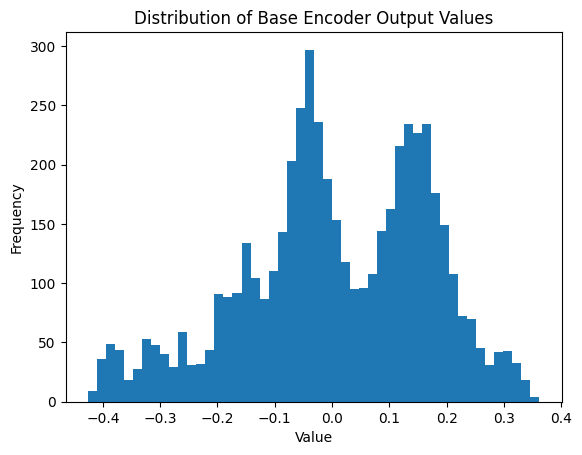

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16, temporal_filters=16, temporal_kernel_size=48):
        super(BaseEncoder, self).__init__()

        # Spatial Convolution
        self.spatial_conv = nn.Conv1d(
            in_channels=num_channels,
            out_channels=spatial_filters,
            kernel_size=1
        )

        # Temporal Convolution
        self.temporal_kernel_size = temporal_kernel_size
        self.temporal_conv = nn.Conv1d(
            in_channels=spatial_filters,
            out_channels=temporal_filters,
            kernel_size=temporal_kernel_size
        )

        # Batch Normalization (if you had this in your original code)
        self.batch_norm = nn.BatchNorm1d(temporal_filters)

        # Dropout (if you had this in your original code)
        self.dropout = nn.Dropout(p=0.5)

        # Activation Function
        self.activation = nn.ELU()

        # Additional Temporal Convolution Layer (if applicable)
        self.extra_temporal_conv = nn.Conv1d(
            in_channels=temporal_filters,
            out_channels=temporal_filters,
            kernel_size=3,
            padding=1  # To maintain the length
        )

    def forward(self, x):
        # x shape: [batch_size, num_channels, num_timepoints]

        # Spatial Convolution
        x = self.spatial_conv(x)  # Shape: [batch_size, spatial_filters, num_timepoints]
        x = self.activation(x)

        # Apply asymmetric padding manually before temporal convolution
        left_pad = (self.temporal_kernel_size - 1) // 2
        right_pad = self.temporal_kernel_size // 2
        x = F.pad(x, (left_pad, right_pad))  # Apply padding: (left, right)

        # Temporal Convolution
        x = self.temporal_conv(x)  # Shape: [batch_size, temporal_filters, num_timepoints]
        x = self.activation(x)

        # Batch Normalization
        x = self.batch_norm(x)

        # Dropout
        x = self.dropout(x)

        # Additional Temporal Convolution (if applicable)
        x = self.extra_temporal_conv(x)
        x = self.activation(x)

        return x  # Final output shape: [batch_size, temporal_filters, num_timepoints]

# ---------------------------------------------------------------
# Reshape Function for DE Features
# ---------------------------------------------------------------
def reshape_for_encoder(segment, num_channels=62):
    """
    Reshape flattened differential entropy features to [batch_size, num_channels, num_timepoints].
    """
    batch_size = segment.shape[0]
    num_timepoints = segment.shape[1] // num_channels
    return segment.view(batch_size, num_channels, num_timepoints)

# ---------------------------------------------------------------
# Test the Base Encoder
# ---------------------------------------------------------------
if __name__ == "__main__":
    # Example input tensors
    batch_size = 8
    num_channels = 62
    num_timepoints = 200  # Adjust this based on your DE feature extraction length

    # Create dummy DE features with shape: [batch_size, num_channels * num_timepoints]
    segments_a = torch.rand((batch_size, num_channels * num_timepoints))
    segments_b = torch.rand((batch_size, num_channels * num_timepoints))

    # Reshape DE features to [batch_size, num_channels, num_timepoints]
    segments_a_reshaped = reshape_for_encoder(segments_a, num_channels)
    segments_b_reshaped = reshape_for_encoder(segments_b, num_channels)

    # Initialize the Base Encoder
    base_encoder = BaseEncoder(num_channels=num_channels)

    # Forward pass for segments_a and segments_b
    output_a = base_encoder(segments_a_reshaped)
    output_b = base_encoder(segments_b_reshaped)

    print(f"Input A Shape: {segments_a_reshaped.shape}")  # Expected: [batch_size, num_channels, num_timepoints]
    print(f"Input B Shape: {segments_b_reshaped.shape}")  # Expected: [batch_size, num_channels, num_timepoints]
    print(f"Output A Shape: {output_a.shape}")            # Expected: [batch_size, temporal_filters, num_timepoints]
    print(f"Output B Shape: {output_b.shape}")            # Expected: [batch_size, temporal_filters, num_timepoints]
            # Calculate statistics
    print(f"Output Mean: {output.mean().item():.4f}")
    print(f"Output Std: {output.std().item():.4f}")
    print(f"Output Min: {output.min().item():.4f}")
    print(f"Output Max: {output.max().item():.4f}")

    # Plot the distribution of output values
    plt.hist(output.detach().cpu().numpy().flatten(), bins=50)
    plt.title("Distribution of Base Encoder Output Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

Projector

Encoded A Shape: torch.Size([8, 16, 200])
Encoded B Shape: torch.Size([8, 16, 200])
Projected A Shape: torch.Size([8, 640])
Projected B Shape: torch.Size([8, 640])
Loss: 0.0067
Gradients for Base Encoder:
spatial_conv.weight: grad norm = 0.0077
spatial_conv.bias: grad norm = 0.0012
temporal_conv.weight: grad norm = 0.0253
temporal_conv.bias: grad norm = 0.0001
batch_norm.weight: grad norm = 0.0031
batch_norm.bias: grad norm = 0.0008
extra_temporal_conv.weight: grad norm = 0.0123
extra_temporal_conv.bias: grad norm = 0.0009

Gradients for Projector:
spatial_conv.weight: grad norm = 0.0064
spatial_conv.bias: grad norm = 0.0017
temporal_conv.weight: grad norm = 0.0099
temporal_conv.bias: grad norm = 0.0015


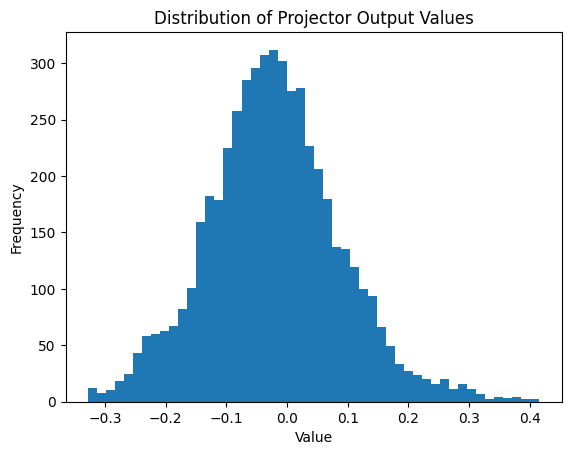

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Base Encoder Definition
# ---------------------------------------------------------------
class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16, temporal_filters=16, temporal_kernel_size=48):
        super(BaseEncoder, self).__init__()

        # Spatial Convolution
        self.spatial_conv = nn.Conv1d(
            in_channels=num_channels,
            out_channels=spatial_filters,
            kernel_size=1
        )

        # Temporal Convolution
        self.temporal_kernel_size = temporal_kernel_size
        self.temporal_conv = nn.Conv1d(
            in_channels=spatial_filters,
            out_channels=temporal_filters,
            kernel_size=temporal_kernel_size
        )

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(temporal_filters)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Activation Function
        self.activation = nn.ELU()

        # Additional Temporal Convolution
        self.extra_temporal_conv = nn.Conv1d(
            in_channels=temporal_filters,
            out_channels=temporal_filters,
            kernel_size=3,
            padding=1  # To maintain the length
        )

    def forward(self, x):
        # x shape: [batch_size, num_channels, num_timepoints]

        # Spatial Convolution
        x = self.spatial_conv(x)
        x = self.activation(x)

        # Apply asymmetric padding manually before temporal convolution
        left_pad = (self.temporal_kernel_size - 1) // 2
        right_pad = self.temporal_kernel_size // 2
        x = F.pad(x, (left_pad, right_pad))

        # Temporal Convolution
        x = self.temporal_conv(x)
        x = self.activation(x)

        # Batch Normalization
        x = self.batch_norm(x)

        # Dropout
        x = self.dropout(x)

        # Additional Temporal Convolution
        x = self.extra_temporal_conv(x)
        x = self.activation(x)

        return x

# ---------------------------------------------------------------
# Projector Definition
# ---------------------------------------------------------------
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, temporal_filters=32, avg_pool_kernel=10, temporal_kernel_size=3):
        super(Projector, self).__init__()

        # Average Pooling
        self.avg_pool = nn.AvgPool1d(kernel_size=avg_pool_kernel, stride=avg_pool_kernel)

        # Spatial Convolution
        self.spatial_conv = nn.Conv1d(
            in_channels=spatial_filters,
            out_channels=temporal_filters,
            kernel_size=1
        )

        # Temporal Convolution
        self.temporal_conv = nn.Conv1d(
            in_channels=temporal_filters,
            out_channels=temporal_filters,
            kernel_size=temporal_kernel_size,
            padding=1
        )

        # Activation Function
        self.activation = nn.ELU()

    def forward(self, x):
        # Average Pooling
        x = self.avg_pool(x)  # Reduces time dimension

        # Spatial Convolution
        x = self.spatial_conv(x)
        x = self.activation(x)

        # Temporal Convolution
        x = self.temporal_conv(x)
        x = self.activation(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        return x

# ---------------------------------------------------------------
# Reshape Function for DE Features
# ---------------------------------------------------------------
def reshape_for_encoder(segment, num_channels=62):
    batch_size = segment.shape[0]
    num_timepoints = segment.shape[1] // num_channels
    return segment.view(batch_size, num_channels, num_timepoints)

# ---------------------------------------------------------------
# Main Function to Test Integration
# ---------------------------------------------------------------
if __name__ == "__main__":
    # Example input tensors
    batch_size = 8
    num_channels = 62
    num_timepoints = 200  # Adjust based on DE feature length

    # Create dummy DE features
    segments_a = torch.rand((batch_size, num_channels * num_timepoints))
    segments_b = torch.rand((batch_size, num_channels * num_timepoints))

    # Reshape DE features
    segments_a_reshaped = reshape_for_encoder(segments_a, num_channels)
    segments_b_reshaped = reshape_for_encoder(segments_b, num_channels)

    # Initialize models
    base_encoder = BaseEncoder(num_channels=num_channels)
    projector = Projector()

    # Forward pass through Base Encoder
    encoded_a = base_encoder(segments_a_reshaped)
    encoded_b = base_encoder(segments_b_reshaped)

    print(f"Encoded A Shape: {encoded_a.shape}")  # Expected: [batch_size, 16, num_timepoints]
    print(f"Encoded B Shape: {encoded_b.shape}")  # Expected: [batch_size, 16, num_timepoints]

    # Forward pass through Projector
    projected_a = projector(encoded_a)
    projected_b = projector(encoded_b)

    print(f"Projected A Shape: {projected_a.shape}")  # Expected: [batch_size, 640]
    print(f"Projected B Shape: {projected_b.shape}")  # Expected: [batch_size, 640]

    # Compute gradient flow
    loss = (projected_a - projected_b).pow(2).mean()
    loss.backward()

    print(f"Loss: {loss.item():.4f}")

    # Check gradient flow for Base Encoder and Projector
    print("Gradients for Base Encoder:")
    for name, param in base_encoder.named_parameters():
        if param.grad is not None:
            print(f"{name}: grad norm = {param.grad.norm().item():.4f}")

    print("\nGradients for Projector:")
    for name, param in projector.named_parameters():
        if param.grad is not None:
            print(f"{name}: grad norm = {param.grad.norm().item():.4f}")

    # Plot distribution of Projector output values
    plt.hist(projected_a.detach().cpu().numpy().flatten(), bins=50)
    plt.title("Distribution of Projector Output Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


Constrastive Loss

In [34]:
import torch
import torch.nn.functional as F

def contrastive_loss(embeddings_a, embeddings_b, temperature=0.5):
    # Normalize the embeddings
    embeddings_a = F.normalize(embeddings_a, dim=1)
    embeddings_b = F.normalize(embeddings_b, dim=1)
    
    # Concatenate embeddings
    embeddings = torch.cat([embeddings_a, embeddings_b], dim=0)
    
    # Compute cosine similarity matrix
    similarities = torch.matmul(embeddings, embeddings.T) / temperature
    
    # Clamp similarities to avoid extreme values
    similarities = torch.clamp(similarities, min=-5.0, max=5.0)
    
    # Create labels for positive pairs
    batch_size = embeddings_a.shape[0]
    labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)
    labels = labels.to(embeddings.device)
    
    # Compute contrastive loss
    loss = F.cross_entropy(similarities, labels)
    
    return loss

# Example usage
loss = contrastive_loss(embeddings_a, embeddings_b, temperature=0.5)
print(f"Contrastive Loss: {loss.item():.4f}")


Contrastive Loss: 2.5627


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import gzip
import copy
from torch.utils.tensorboard import SummaryWriter

# ---------------------------------------------------------------
# Base Encoder Definition
# ---------------------------------------------------------------
class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16, temporal_filters=16, temporal_kernel_size=48):
        super(BaseEncoder, self).__init__()

        self.spatial_conv = nn.Conv1d(num_channels, spatial_filters, kernel_size=1)
        self.temporal_kernel_size = temporal_kernel_size
        self.temporal_conv = nn.Conv1d(spatial_filters, temporal_filters, kernel_size=temporal_kernel_size)
        self.batch_norm = nn.BatchNorm1d(temporal_filters)
        self.dropout = nn.Dropout(p=0.3)  # Reduced dropout rate
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.spatial_conv(x)
        x = self.activation(x)
        left_pad = (self.temporal_kernel_size - 1) // 2
        right_pad = self.temporal_kernel_size // 2
        x = F.pad(x, (left_pad, right_pad))
        x = self.temporal_conv(x)
        x = self.activation(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x

# ---------------------------------------------------------------
# Projector Definition
# ---------------------------------------------------------------
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, temporal_filters=32, avg_pool_kernel=2, temporal_kernel_size=3):
        super(Projector, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=avg_pool_kernel, stride=avg_pool_kernel)
        self.spatial_conv = nn.Conv1d(spatial_filters, temporal_filters, kernel_size=1)
        self.temporal_conv = nn.Conv1d(temporal_filters, temporal_filters, kernel_size=temporal_kernel_size, padding=1)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.avg_pool(x)
        x = self.spatial_conv(x)
        x = self.activation(x)
        x = self.temporal_conv(x)
        x = self.activation(x)
        x = x.view(x.size(0), -1)
        return x

# ---------------------------------------------------------------
# Contrastive Loss Function
# ---------------------------------------------------------------
def contrastive_loss(embeddings_a, embeddings_b, temperature=0.1):
    embeddings_a = F.normalize(embeddings_a, dim=1)
    embeddings_b = F.normalize(embeddings_b, dim=1)

    batch_size = embeddings_a.size(0)
    labels = torch.arange(batch_size).to(embeddings_a.device)
    
    logits = torch.matmul(embeddings_a, embeddings_b.T) / temperature
    loss = F.cross_entropy(logits, labels)
    return loss

# ---------------------------------------------------------------
# Dataset Class for Contrastive Pairs from Files
# ---------------------------------------------------------------
class ContrastiveDataset(Dataset):
    def __init__(self, data_dir, num_channels=62, num_timepoints=200):
        self.filepaths = [os.path.join(data_dir, f"batch_{i}_pairs.pkl.gz") for i in range(1000)]
        self.num_channels = num_channels
        self.num_timepoints = num_timepoints

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        with gzip.open(filepath, 'rb') as f:
            pairs = pickle.load(f)

        # Randomly select a pair from the batch
        segment_a, segment_b, _ = pairs[torch.randint(0, len(pairs), (1,)).item()]

        # Ensure each segment is reshaped to [num_channels, num_timepoints]
        segment_a = torch.tensor(segment_a, dtype=torch.float32)
        segment_b = torch.tensor(segment_b, dtype=torch.float32)

        # Reshape to [num_channels, num_timepoints]
        segment_a = segment_a.view(self.num_channels, -1)
        segment_b = segment_b.view(self.num_channels, -1)

        # Pad or truncate to ensure the time dimension is consistent
        segment_a = F.pad(segment_a, (0, max(0, self.num_timepoints - segment_a.shape[1])))
        segment_b = F.pad(segment_b, (0, max(0, self.num_timepoints - segment_b.shape[1])))

        segment_a = segment_a[:, :self.num_timepoints]
        segment_b = segment_b[:, :self.num_timepoints]

        return segment_a, segment_b

# ---------------------------------------------------------------
# Training Loop with Checkpoints and Early Stopping
# ---------------------------------------------------------------
def train_model(base_encoder, projector, dataloader, criterion, optimizer, num_epochs=100, patience=30, device='cpu', checkpoint_path='best_model.pth'):
    writer = SummaryWriter(log_dir='runs/contrastive_training')

    base_encoder.to(device)
    projector.to(device)

    best_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        total_loss = 0.0
        for segments_a, segments_b in dataloader:
            segments_a, segments_b = segments_a.to(device), segments_b.to(device)

            optimizer.zero_grad()
            embeddings_a = projector(base_encoder(segments_a))
            embeddings_b = projector(base_encoder(segments_b))

            loss = criterion(embeddings_a, embeddings_b)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(list(base_encoder.parameters()) + list(projector.parameters()), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        writer.add_scalar('Loss/train', avg_loss, epoch + 1)

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = copy.deepcopy({'base_encoder': base_encoder.state_dict(), 'projector': projector.state_dict()})
            torch.save(best_model_state, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # Log embeddings to TensorBoard
        writer.add_histogram('Embeddings/embeddings_a', embeddings_a, epoch)
        writer.add_histogram('Embeddings/embeddings_b', embeddings_b, epoch)

    writer.close()

# ---------------------------------------------------------------
# Main Function to Run Training
# ---------------------------------------------------------------
if __name__ == "__main__":
    # Path to the contrastive pairs directory
    data_dir = r"C:\Users\tahir\Documents\EEg-based-Emotion-Recognition\contrastive_pairs"

    # Create Dataset and DataLoader
    dataset = ContrastiveDataset(data_dir)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize Models
    base_encoder = BaseEncoder(num_channels=62)
    projector = Projector()

    # Define Optimizer and Criterion
    optimizer = optim.Adam(list(base_encoder.parameters()) + list(projector.parameters()), lr=0.001)
    criterion = lambda a, b: contrastive_loss(a, b, temperature=0.1)

    # Train the Model
    train_model(base_encoder, projector, dataloader, criterion, optimizer, num_epochs=100, patience=30, device='cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/100], Loss: 3.4321
Checkpoint saved at epoch 1
Epoch [2/100], Loss: 3.4253
Checkpoint saved at epoch 2
Epoch [3/100], Loss: 3.4246
Checkpoint saved at epoch 3
Epoch [4/100], Loss: 3.4219
Checkpoint saved at epoch 4
Epoch [5/100], Loss: 3.4243


KeyboardInterrupt: 